## Credit One Task 3 - Pipeline - Smitha Palampalli


Updated: 2020.09.26


#### The objective of this task is to perform Modelling on Credit One data to:
 * Learn and practice Regression modelling on Credit One data
 * Learn to use Recursive Feature Elimination and identify the best features to model with
 * Determine if a Regression model can be built to accurately predict the credit limit to assign to a customer using the available features
 * Determine if it is possible to predict if a customer will default on next month's payment using the available features
 * Determine the best Classification model to use to make these 'default' predictions
 
###### Note: certain cells in this note book run for 3-5 minutes each, especially the cells used for Recursive Feature Elimination, and those used to build multiple models on the same test data in a loop, to look for best scores

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#SKLearn
from sklearn.model_selection import train_test_split, cross_val_score

# SKLearn Recursive Feature Elimination
from sklearn.feature_selection import RFE

#SKLearn Classification Models and metrics
#models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#SKLearn Regression Models and metrics
#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
#metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

#For plotting decision tree
from sklearn.tree import plot_tree

## Importing Data

In [2]:
# Import previously pre-processed and cleaned data from task 2 that was saved into a CSV
credit = pd.read_csv('Credit_One_Data_After_T2.csv')

## Evaluating Data 

In [3]:
credit.head()

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,MARRIAGE_LABEL,PMT_DEFAULT_IND,age_bins,limit_bal_bins,PAY_0_default,PAY_2_default,PAY_3_default,PAY_4_default,PAY_5_default,PAY_6_default
0,0,1,20000,female,university,1,24,2,2,-1,...,Married,0,20-29,below $200K,1,1,0,0,0,0
1,1,2,120000,female,university,2,26,-1,2,0,...,Single,0,20-29,below $200K,0,1,0,0,0,1
2,2,3,90000,female,university,2,34,0,0,0,...,Single,1,30-39,below $200K,0,0,0,0,0,0
3,3,4,50000,female,university,1,37,0,0,0,...,Married,1,30-39,below $200K,0,0,0,0,0,0
4,4,5,50000,male,university,1,57,-1,0,-1,...,Married,1,50 and above,below $200K,0,0,0,0,0,0


In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  30000 non-null  int64 
 1   ID                          30000 non-null  int64 
 2   LIMIT_BAL                   30000 non-null  int64 
 3   SEX                         30000 non-null  object
 4   EDUCATION                   30000 non-null  object
 5   MARRIAGE                    30000 non-null  int64 
 6   AGE                         30000 non-null  int64 
 7   PAY_0                       30000 non-null  int64 
 8   PAY_2                       30000 non-null  int64 
 9   PAY_3                       30000 non-null  int64 
 10  PAY_4                       30000 non-null  int64 
 11  PAY_5                       30000 non-null  int64 
 12  PAY_6                       30000 non-null  int64 
 13  BILL_AMT1                   30000 non-null  in

## Preprocessing Data

###### Most of the pre - processing was already done in task 1 and task 2.  There are no nulls or duplicates. Most of the data types are integers.  Refer to C2T1.ipynb and C2_T2_Smitha.pynb for  preprocessing. 
###### There are 2 things I need to do here in preprocessing, since I imported from .csv file : 
 * change the object dtypes to category
 * drop the first column (Called Unnamed: 0) which seems to be the index of the original dataframe. It is not needed for Modelling

In [5]:
#convert object datatypes to categorical datatypes
credit['SEX'] = credit['SEX'].astype('category')
credit['EDUCATION'] = credit['EDUCATION'].astype('category')
credit['default payment next month'] = credit['default payment next month'].astype('category')
credit['MARRIAGE_LABEL'] = credit['MARRIAGE_LABEL'].astype('category')
credit['age_bins'] = credit['age_bins'].astype('category')
credit['limit_bal_bins'] = credit['limit_bal_bins'].astype('category')

In [6]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Unnamed: 0                  30000 non-null  int64   
 1   ID                          30000 non-null  int64   
 2   LIMIT_BAL                   30000 non-null  int64   
 3   SEX                         30000 non-null  category
 4   EDUCATION                   30000 non-null  category
 5   MARRIAGE                    30000 non-null  int64   
 6   AGE                         30000 non-null  int64   
 7   PAY_0                       30000 non-null  int64   
 8   PAY_2                       30000 non-null  int64   
 9   PAY_3                       30000 non-null  int64   
 10  PAY_4                       30000 non-null  int64   
 11  PAY_5                       30000 non-null  int64   
 12  PAY_6                       30000 non-null  int64   
 13  BILL_AMT1       

## Feature Engineering

###### Create new features using the features we have and run some basic EDA on the new features to visualize the relationship of new features with 'default payment next month'

###### With Task 2 I had created new bins for PAY_0 through PAY_6 features as follows:
 * Discretize PAY_0, PAY_2, PAY_3, PAY_4, PAY_5 and PAY_6 into payment made or delayed. -1, -2 and 0 will be considered as Payment made. 1 through 8 will be considered payment defaulted

###### Now create a new column that's the average of all the 6 PAY features. Round it up to 1 or 0

In [7]:
credit = credit.assign(PAY_avg = (credit['PAY_0_default']
                                  + credit['PAY_2_default'] 
                                  + credit['PAY_3_default'] 
                                  + credit['PAY_4_default'] 
                                  + credit['PAY_5_default'] 
                                  + credit['PAY_6_default'])/6)

In [8]:
#what are the distinct values we see?
credit['PAY_avg'].value_counts()

0.000000    19931
0.166667     4426
0.333333     1899
1.000000     1341
0.500000     1154
0.666667      951
0.833333      298
Name: PAY_avg, dtype: int64

In [9]:
# round up the PAY_avergae value using np.around
credit['PAY_avg'] = np.around(credit['PAY_avg'])

In [10]:
# ensure no nulls are present
credit.isnull().any().sum()

0

###### Create a crosstab to see percentages of default next month if customer has defaulted in average of sixth months. We can see that if a customer is showing an average default across 6 months as default, there is a 64% chance they will default next month

In [11]:
pd.crosstab(index = credit['default payment next month'], 
            columns = credit['PAY_avg'],
            normalize = 'columns').applymap(lambda x: "{0:.2f}%".format(100*x))

PAY_avg,0.0,1.0
default payment next month,,
default,18.16%,64.05%
not default,81.84%,35.95%


###### Calculate average of bill_amt1 through 6. See if it has any bearing on default payment next month. Not showing a lot of difference

In [12]:
credit = credit.assign(BILL_AMT_avg = (credit['BILL_AMT1']
                                  + credit['BILL_AMT2'] 
                                  + credit['BILL_AMT3'] 
                                  + credit['BILL_AMT4'] 
                                  + credit['BILL_AMT5'] 
                                  + credit['BILL_AMT6'])/6)

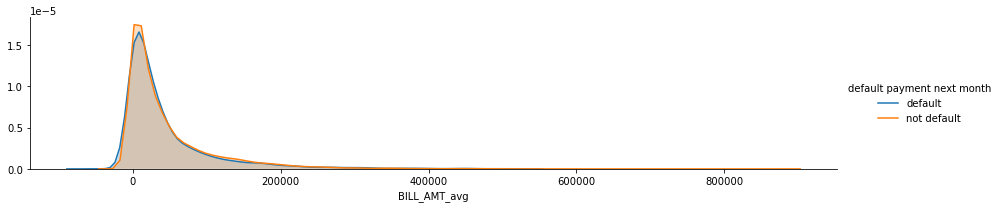

In [13]:
fig = sns.FacetGrid(credit, hue='default payment next month', aspect=4)
fig.map(sns.kdeplot, 'BILL_AMT_avg', shade=True)
fig.add_legend()

###### Calculate average of pay_amt1 through 6. See if it has any bearing on default payment next month by plotting a Box Plot. I am unable to distinguish any useful information, and it seems like tthere are specific outliers that cause the graph to be skewed.

In [14]:
credit = credit.assign(PAY_AMT_avg = (credit['PAY_AMT1']
                                  + credit['PAY_AMT2'] 
                                  + credit['PAY_AMT3'] 
                                  + credit['PAY_AMT4'] 
                                  + credit['PAY_AMT5'] 
                                  + credit['PAY_AMT6'])/6)

[Text(0.5, 1.0, 'Box Plot to show Relationship between Payment Received and Payment Default')]

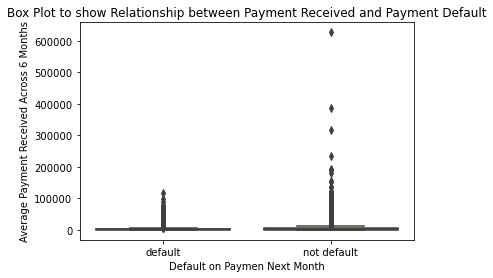

In [15]:
fg = sns.boxplot(credit['default payment next month'], credit['PAY_AMT_avg'])
fg.set(xlabel = 'Default on Paymen Next Month', ylabel = 'Average Payment Received Across 6 Months')
fg.set (title = 'Box Plot to show Relationship between Payment Received and Payment Default')

In [16]:
credit.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Unnamed: 0                  30000 non-null  int64   
 1   ID                          30000 non-null  int64   
 2   LIMIT_BAL                   30000 non-null  int64   
 3   SEX                         30000 non-null  category
 4   EDUCATION                   30000 non-null  category
 5   MARRIAGE                    30000 non-null  int64   
 6   AGE                         30000 non-null  int64   
 7   PAY_0                       30000 non-null  int64   
 8   PAY_2                       30000 non-null  int64   
 9   PAY_3                       30000 non-null  int64   
 10  PAY_4                       30000 non-null  int64   
 11  PAY_5                       30000 non-null  int64   
 12  PAY_6                       30000 non-null  int64   
 13  BILL_AMT1       

## Modelling

### 1. Regression Modelling with LIMIT_BAL as dependent variable

###### Slicing with LIMIT_BAL as dependent variable

In [17]:
# independent variables
X = credit[['SEX_ID', 'EDUCATION_ID', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
            'PAY_0_default', 'PAY_2_default', 'PAY_3_default', 'PAY_4_default', 'PAY_5_default', 'PAY_6_default',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
            'PAY_avg', 'BILL_AMT_avg', 'PAY_AMT_avg', 'PMT_DEFAULT_IND' ]]

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEX_ID           30000 non-null  int64  
 1   EDUCATION_ID     30000 non-null  int64  
 2   MARRIAGE         30000 non-null  int64  
 3   AGE              30000 non-null  int64  
 4   PAY_0            30000 non-null  int64  
 5   PAY_2            30000 non-null  int64  
 6   PAY_3            30000 non-null  int64  
 7   PAY_4            30000 non-null  int64  
 8   PAY_5            30000 non-null  int64  
 9   PAY_6            30000 non-null  int64  
 10  PAY_0_default    30000 non-null  int64  
 11  PAY_2_default    30000 non-null  int64  
 12  PAY_3_default    30000 non-null  int64  
 13  PAY_4_default    30000 non-null  int64  
 14  PAY_5_default    30000 non-null  int64  
 15  PAY_6_default    30000 non-null  int64  
 16  BILL_AMT1        30000 non-null  int64  
 17  BILL_AMT2   

In [19]:
X.head(5)

,SEX_ID,EDUCATION_ID,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_avg,BILL_AMT_avg,PAY_AMT_avg,PMT_DEFAULT_IND
0,0,3,1,24,2,2,-1,-1,-2,-2,...,0,689,0,0,0,0,0.0,1284.000000,114.833333,0
1,0,3,2,26,-1,2,0,0,0,2,...,0,1000,1000,1000,0,2000,0.0,2846.166667,833.333333,0
2,0,3,2,34,0,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0.0,16942.166667,1836.333333,1
3,0,3,1,37,0,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0.0,38555.666667,1398.000000,1
4,1,3,1,57,-1,0,-1,0,0,0,...,2000,36681,10000,9000,689,679,0.0,18223.166667,9841.500000,1


In [20]:
# dependent variable
y = credit['LIMIT_BAL']

In [21]:
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

#### Using cross_val_score to evaluate between 4 regression models

In [22]:
# create an array to store 4 regression models
algosArrBal = []
algosArrBal.append(('Linear Regresson', LinearRegression()))
algosArrBal.append(('Random Forest Regresson', RandomForestRegressor()))
algosArrBal.append(('Support Vector Regresson', SVR()))
algosArrBal.append(('Decision Tree Regressor', DecisionTreeRegressor()))

In [23]:
# run the models on the dataset and compute score.
# scoring method used here is r2
# Best possible score is 1.0. Negative values are possible because the model can be arbitrarily worse.
# Takes 2-3 minutes to run
resultsBal = []
namesBal = []
for name, model in algosArrBal:
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    namesBal.append(name)
    resultsBal.append(result)

In [24]:
for i in range(len(namesBal)):
    print(namesBal[i],resultsBal[i].mean())

Linear Regresson 0.3532717886837762
Random Forest Regresson 0.4659261823313301
Support Vector Regresson -0.05041050155334751
Decision Tree Regressor -0.06747469445573133


###### None of the models give a good score for predicting LIMIT_BAL using the other features. However, continue with building a model and tuning its parameters, just to get practice doing this for regression models. Building a Random Forest model as it has the highest score(.24)

###### Before modelling, use SKLearn's RFE - Recursive Feature Elimination to reduce the number of features needed for modelling. RFE is an algorithm that runs through a subset of the features recursively to determine which of the features give the best score for the model.

In [25]:
# Set up the model to be Random Forest as it has yielded the highest score so far among the regression models tried
# using cross_val_score above
estimator = RandomForestRegressor(max_depth = 5)

# set up the RFE selector to model with 8 features at a time
selector = RFE(estimator, n_features_to_select=8, step=1)

# run the selector to fit the data. THIS TAKES ABOUT 5 MIN TO RUN,
# as it needs to recursively run the model for 8 features 
# at a time among the 30 or so features in X.
selector = selector.fit(X, y)

# print the best 8 features.
selector.support_

array([False,  True, False,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False])

In [26]:
# see how the selector ranked each of the features. Lower number is higher ranking
selector.ranking_

array([12,  1, 21,  1,  3,  1,  1, 16, 11, 15, 19, 20, 18, 22, 23, 25,  1,
        5,  1,  4,  1,  8, 13,  7, 10, 14,  6,  9, 24,  2,  1, 17])

###### The RFE feature selector recommends the following 8 features for Random Forest Regressor to get the best score:
###### 'EDUCATION_ID', 'AGE', 'PAY_2', 'PAY_3', 'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT5', 'PAY_AMT_avg'

###### Modelling with Random Forest Regressor using the features suggested by RFE

In [27]:
# independent variables
X = credit[['EDUCATION_ID', 'AGE', 'PAY_2', 'PAY_3', 'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT5', 'PAY_AMT_avg']]

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EDUCATION_ID  30000 non-null  int64  
 1   AGE           30000 non-null  int64  
 2   PAY_2         30000 non-null  int64  
 3   PAY_3         30000 non-null  int64  
 4   BILL_AMT1     30000 non-null  int64  
 5   BILL_AMT3     30000 non-null  int64  
 6   BILL_AMT5     30000 non-null  int64  
 7   PAY_AMT_avg   30000 non-null  float64
dtypes: float64(1), int64(7)
memory usage: 1.8 MB


In [29]:
X.head(5)

,EDUCATION_ID,AGE,PAY_2,PAY_3,BILL_AMT1,BILL_AMT3,BILL_AMT5,PAY_AMT_avg
0,3,24,2,-1,3913,689,0,114.833333
1,3,26,2,0,2682,2682,3455,833.333333
2,3,34,0,0,29239,13559,14948,1836.333333
3,3,37,0,0,46990,49291,28959,1398.000000
4,3,57,0,-1,8617,35835,19146,9841.500000


In [30]:
# dependent variable
y = credit['LIMIT_BAL']

In [31]:
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

###### Splitting into Training and Testing Data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

In [33]:
X_train.head()

,EDUCATION_ID,AGE,PAY_2,PAY_3,BILL_AMT1,BILL_AMT3,BILL_AMT5,PAY_AMT_avg
26340,0,26,0,2,65421,63156,53383,2391.666667
3877,3,23,0,0,47662,42162,19286,1258.000000
27081,3,31,0,0,73414,72368,78845,3766.666667
5440,3,39,0,2,22033,24372,25617,1483.333333
22164,0,30,-1,2,6043,6527,-7,2078.166667


In [34]:
y_train.head()

26340    150000
3877      50000
27081     80000
5440     120000
22164    150000
Name: LIMIT_BAL, dtype: int64

###### Build the Random Forest Model

In [35]:
# initialize the algorithm. Try with different depths, 8 seems to work well
algoRF = RandomForestRegressor(max_depth = 8) 

# train the model with the train data
modelRF = algoRF.fit(X_train, y_train)

In [36]:
# Predict and check scores
predRF = modelRF.predict(X_test)

In [37]:
# Now check scores. Checking 2 kinds of scores here - RMSE (Root Mean Square Error) and R2.
# Note that the R Squared score for the Linear Regression model using train-test-split 
# is very similar to the cross_val_score for Linear Regression above.
# As learned above, for R2 scores - 1.0 is the highest value. Values can be negative. 
# For RMSE scores - The smaller the mean squared error - the closer we are to finding line of best fit.
r2RF = r2_score(y_test,predRF)
rmseRF = mean_squared_error(y_test, predRF, squared = False) # Squared: If True returns MSE, if False returns RMSE 
print('Predicting Balance using RFR: R Squared: %.3f' % r2RF)
print('Predicting Balance using RFR: RMSE: %.3f' % rmseRF)

Predicting Balance using RFR: R Squared: 0.462
Predicting Balance using RFR: RMSE: 95848.051


Text(0, 0.5, 'Predictions')

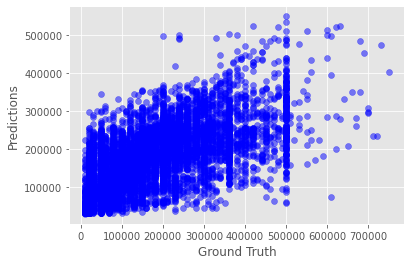

In [38]:
# Create a scatter plot between Y test and predictions.
plt.style.use('ggplot')
plt.scatter(y_test, predRF, color='blue', alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')

[Text(768.7788803317536, 513.4, 'PAY_AMT_avg <= 4873.5\nmse = 16915141982.615\nsamples = 14312\nvalue = 168104.668'),
 Text(394.61640995260666, 453.0, 'PAY_2 <= -0.5\nmse = 12553856428.345\nsamples = 10148\nvalue = 134289.791'),
 Text(195.44875592417063, 392.6, 'AGE <= 25.5\nmse = 13849513461.644\nsamples = 3149\nvalue = 201703.899'),
 Text(93.385663507109, 332.2, 'AGE <= 22.5\nmse = 4681312868.949\nsamples = 259\nvalue = 86545.455'),
 Text(47.932464454976305, 271.8, 'BILL_AMT3 <= 3513.0\nmse = 489580246.914\nsamples = 29\nvalue = 33555.556'),
 Text(26.445497630331754, 211.39999999999998, 'BILL_AMT3 <= 1440.0\nmse = 670233196.159\nsamples = 18\nvalue = 39629.63'),
 Text(13.222748815165877, 151.0, 'BILL_AMT3 <= 214.0\nmse = 325000000.0\nsamples = 11\nvalue = 31666.667'),
 Text(6.611374407582939, 90.59999999999997, 'BILL_AMT5 <= 805.0\nmse = 338775510.204\nsamples = 7\nvalue = 35714.286'),
 Text(3.3056872037914693, 30.199999999999932, 'mse = 202366863.905\nsamples = 6\nvalue = 32307.692'

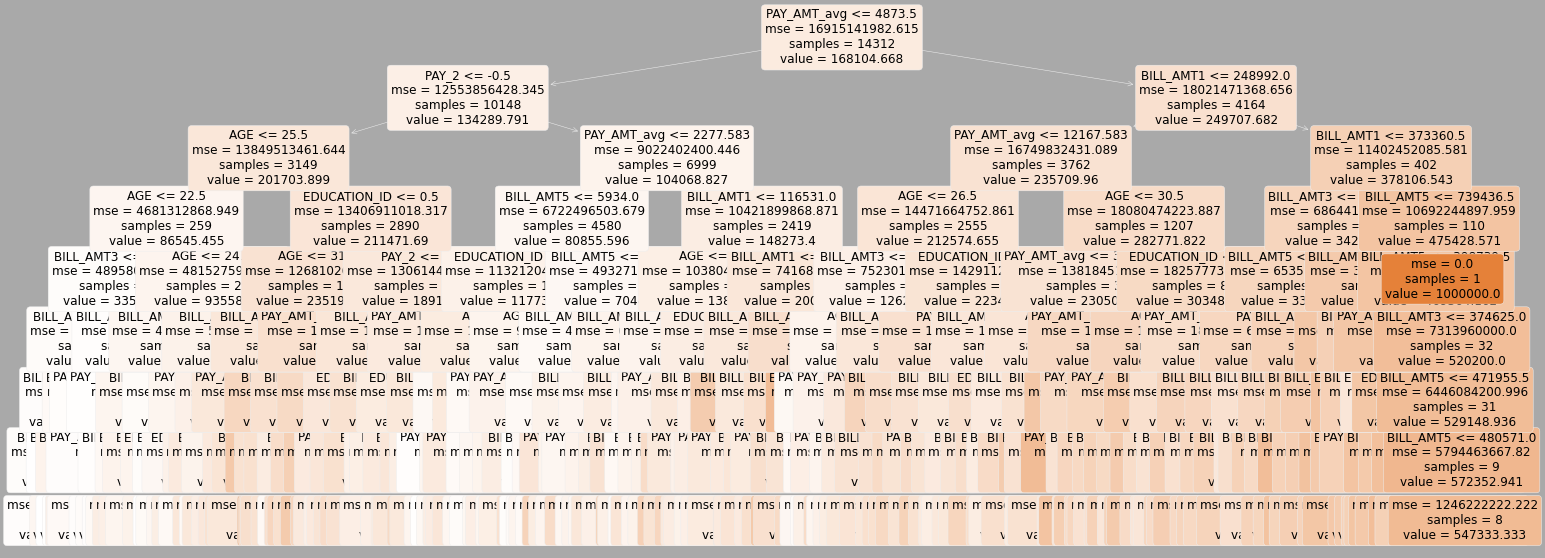

In [39]:
# plot the last tree
plt.figure(figsize = (25, 10), facecolor = 'darkgrey')

plot_tree(modelRF.estimators_[99],
        filled = True,
        rounded = True,
        fontsize = 12, 
        feature_names = ['EDUCATION_ID', 'AGE', 'PAY_2', 'PAY_3', 'BILL_AMT1', 'BILL_AMT3', 'BILL_AMT5', 'PAY_AMT_avg'])

###### With some parameter tuning, we were able to get an R2 score of .46, which is very similar to what we got for the cross-validation-score model, but still can't be used to make accurate predictions

###### Since the scores are not great, try predicting LIMIT_BAL with a different set of features, not based on RFE recommendation, but based on business understanding of data and EDA. Also RFE did not recommend using 'default' field at all, but we want to see if we can predict credit limit such that a customer does not default, so it is important to use 'default' feature in modelling.

In [40]:
# independent variables
X = credit[['SEX_ID', 'EDUCATION_ID', 'MARRIAGE', 'AGE', 'PAY_avg', 'BILL_AMT_avg', 'PMT_DEFAULT_IND']]

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEX_ID           30000 non-null  int64  
 1   EDUCATION_ID     30000 non-null  int64  
 2   MARRIAGE         30000 non-null  int64  
 3   AGE              30000 non-null  int64  
 4   PAY_avg          30000 non-null  float64
 5   BILL_AMT_avg     30000 non-null  float64
 6   PMT_DEFAULT_IND  30000 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.6 MB


In [42]:
X.head(5)

,SEX_ID,EDUCATION_ID,MARRIAGE,AGE,PAY_avg,BILL_AMT_avg,PMT_DEFAULT_IND
0,0,3,1,24,0.0,1284.000000,0
1,0,3,2,26,0.0,2846.166667,0
2,0,3,2,34,0.0,16942.166667,1
3,0,3,1,37,0.0,38555.666667,1
4,1,3,1,57,0.0,18223.166667,1


In [43]:
# dependent variable
y = credit['LIMIT_BAL']

In [44]:
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

###### Splitting into Training and Testing Data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

In [46]:
X_train.head()

,SEX_ID,EDUCATION_ID,MARRIAGE,AGE,PAY_avg,BILL_AMT_avg,PMT_DEFAULT_IND
26340,0,0,2,26,0.0,59458.333333,1
3877,0,3,2,23,0.0,27742.666667,1
27081,1,3,2,31,0.0,74385.333333,1
5440,0,3,2,39,0.0,24549.000000,1
22164,0,0,3,30,0.0,2692.333333,1


In [47]:
y_train.head()

26340    150000
3877      50000
27081     80000
5440     120000
22164    150000
Name: LIMIT_BAL, dtype: int64

###### Build the Random Forest Model

In [48]:
# initialize the algorithm. Try with different depths, 8 seems to work well
algoRF2 = RandomForestRegressor(max_depth = 8) 

# train the model with the train data
modelRF2 = algoRF2.fit(X_train, y_train)

In [49]:
# Predict and check scores
predRF2 = modelRF2.predict(X_test)

In [50]:
# Now check scores. Checking 2 kinds of scores here - RMSE (Root Mean Square Error) and R2.
# Note that the R Squared score for the Linear Regression model using train-test-split 
# is very similar to the cross_val_score for Linear Regression above.
# As learned above, for R2 scores - 1.0 is the highest value. Values can be negative. 
# For RMSE scores - The smaller the mean squared error - the closer we are to finding line of best fit.
r2RF2 = r2_score(y_test,predRF2)
rmseRF2 = mean_squared_error(y_test, predRF2, squared = False) # Squared: If True returns MSE, if False returns RMSE 
print('Predicting Balance using RFR: R Squared: %.3f' % r2RF2)
print('Predicting Balance using RFR: RMSE: %.3f' % rmseRF2)

Predicting Balance using RFR: R Squared: 0.346
Predicting Balance using RFR: RMSE: 105709.781


Text(0, 0.5, 'Predictions')

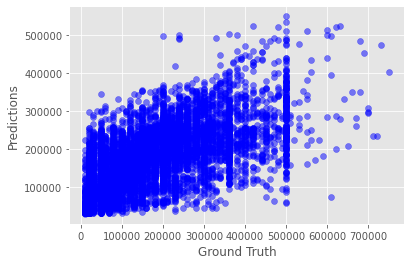

In [51]:
# Create a scatter plot between Y test and predictions.
plt.style.use('ggplot')
plt.scatter(y_test, predRF, color='blue', alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')

[Text(695.1914639778325, 513.4, 'AGE <= 26.5\nmse = 16494309265.154\nsamples = 14285\nvalue = 167322.044'),
 Text(376.45243226600985, 453.0, 'BILL_AMT_avg <= 72719.918\nmse = 6065174372.894\nsamples = 2409\nvalue = 84804.781'),
 Text(203.58066502463055, 392.6, 'AGE <= 24.5\nmse = 4962315853.788\nsamples = 2171\nvalue = 75173.224'),
 Text(100.93134236453201, 332.2, 'BILL_AMT_avg <= 40285.916\nmse = 2017091571.28\nsamples = 1213\nvalue = 54032.258'),
 Text(54.97536945812808, 271.8, 'SEX_ID <= 0.5\nmse = 1826460845.712\nsamples = 1053\nvalue = 49280.576'),
 Text(27.48768472906404, 211.39999999999998, 'AGE <= 22.5\nmse = 2255274824.67\nsamples = 718\nvalue = 56012.378'),
 Text(13.74384236453202, 151.0, 'BILL_AMT_avg <= 30642.083\nmse = 483389952.39\nsamples = 187\nvalue = 34753.521'),
 Text(6.87192118226601, 90.59999999999997, 'BILL_AMT_avg <= 921.333\nmse = 467013527.575\nsamples = 169\nvalue = 31774.194'),
 Text(3.435960591133005, 30.199999999999932, 'mse = 1860000000.0\nsamples = 6\nval

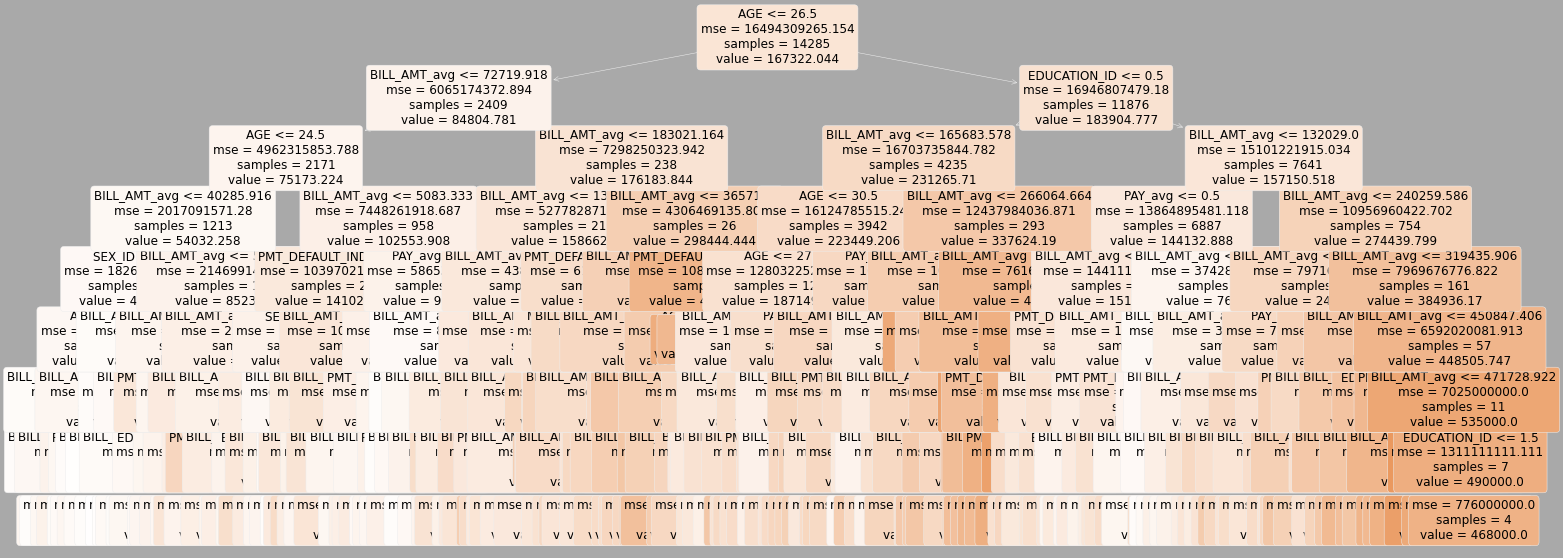

In [52]:
# plot the last tree
plt.figure(figsize = (25, 10), facecolor = 'darkgrey')

plot_tree(modelRF2.estimators_[99],
        filled = True,
        rounded = True,
        fontsize = 12, 
        feature_names = ['SEX_ID', 'EDUCATION_ID', 'MARRIAGE', 'AGE', 'PAY_avg', 'BILL_AMT_avg', 'PMT_DEFAULT_IND'])

###### Since the scores are not great again, try predicting LIMIT_BAL using observations associated with not_default data only

In [53]:
# create a new dataframe with not default observations only.
credit_not_default =  credit[(credit['default payment next month'] == 'not default')]

In [54]:
# take a quick look at the data in the new dataframe
credit_not_default.head(5)

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,limit_bal_bins,PAY_0_default,PAY_2_default,PAY_3_default,PAY_4_default,PAY_5_default,PAY_6_default,PAY_avg,BILL_AMT_avg,PAY_AMT_avg
2,2,3,90000,female,university,2,34,0,0,0,...,below $200K,0,0,0,0,0,0,0.0,16942.166667,1836.333333
3,3,4,50000,female,university,1,37,0,0,0,...,below $200K,0,0,0,0,0,0,0.0,38555.666667,1398.000000
4,4,5,50000,male,university,1,57,-1,0,-1,...,below $200K,0,0,0,0,0,0,0.0,18223.166667,9841.500000
5,5,6,50000,male,graduate school,2,37,0,0,0,...,below $200K,0,0,0,0,0,0,0.0,39685.666667,1295.333333
6,6,7,500000,male,graduate school,2,29,0,0,0,...,$400K to 600K,0,0,0,0,0,0,0.0,454099.166667,30126.500000


In [55]:
# select features
X_not_default = credit_not_default[['SEX_ID', 'EDUCATION_ID', 'MARRIAGE', 'AGE']]

In [56]:
X_not_default.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23364 entries, 2 to 29996
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SEX_ID        23364 non-null  int64
 1   EDUCATION_ID  23364 non-null  int64
 2   MARRIAGE      23364 non-null  int64
 3   AGE           23364 non-null  int64
dtypes: int64(4)
memory usage: 912.7 KB


In [57]:
X_not_default.head(5)

,SEX_ID,EDUCATION_ID,MARRIAGE,AGE
2,0,3,2,34
3,0,3,1,37
4,1,3,1,57
5,1,0,2,37
6,1,0,2,29


In [58]:
# dependent variable
y_not_default = credit_not_default['LIMIT_BAL']

In [59]:
y_not_default.shape

(23364,)

In [60]:
y_not_default.head()

2     90000
3     50000
4     50000
5     50000
6    500000
Name: LIMIT_BAL, dtype: int64

###### Using cross_val_score to evaluate between 4 models

In [61]:
# create an array to store 4 regression models
algosArrBal = []
algosArrBal.append(('Linear Regresson', LinearRegression()))
algosArrBal.append(('Random Forest Regresson', RandomForestRegressor()))
algosArrBal.append(('Support Vector Regresson', SVR()))
algosArrBal.append(('Decision Tree Regressor', DecisionTreeRegressor()))

In [62]:
# run the models on the dataset and compute score.
# scoring method used here is r2
# Best possible score is 1.0. Negative values are possible because the model can be arbitrarily worse.

resultsBal = []
namesBal = []
for name, model in algosArrBal:
    result = cross_val_score(model, X_not_default, y_not_default, cv=3, scoring='r2')
    namesBal.append(name)
    resultsBal.append(result)

In [63]:
for i in range(len(namesBal)):
    print(namesBal[i],resultsBal[i].mean())

Linear Regresson 0.05838064533546546
Random Forest Regresson 0.15834804669252037
Support Vector Regresson -0.03965529379023954
Decision Tree Regressor 0.1496773954975604


###### Again the scores are not great. In fact, they are worse. I conclude that we are unable to determine what credit limit to assign to a customer using any of the four regression models above.

###### Now I will try to see if I can use classification models can predict default behavior using the other features

### 2. Classification Modelling with 'default payment next month' as dependent variable

###### Slicing with 'default payment next month' as dependent variable

In [64]:
# independent variables
X = credit[['LIMIT_BAL', 'SEX_ID', 'EDUCATION_ID', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
            'PAY_0_default', 'PAY_2_default', 'PAY_3_default', 'PAY_4_default', 'PAY_5_default', 'PAY_6_default',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
            'PAY_avg', 'BILL_AMT_avg', 'PAY_AMT_avg']]

In [65]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LIMIT_BAL      30000 non-null  int64  
 1   SEX_ID         30000 non-null  int64  
 2   EDUCATION_ID   30000 non-null  int64  
 3   MARRIAGE       30000 non-null  int64  
 4   AGE            30000 non-null  int64  
 5   PAY_0          30000 non-null  int64  
 6   PAY_2          30000 non-null  int64  
 7   PAY_3          30000 non-null  int64  
 8   PAY_4          30000 non-null  int64  
 9   PAY_5          30000 non-null  int64  
 10  PAY_6          30000 non-null  int64  
 11  PAY_0_default  30000 non-null  int64  
 12  PAY_2_default  30000 non-null  int64  
 13  PAY_3_default  30000 non-null  int64  
 14  PAY_4_default  30000 non-null  int64  
 15  PAY_5_default  30000 non-null  int64  
 16  PAY_6_default  30000 non-null  int64  
 17  BILL_AMT1      30000 non-null  int64  
 18  BILL_A

In [66]:
X.head()

,LIMIT_BAL,SEX_ID,EDUCATION_ID,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_avg,BILL_AMT_avg,PAY_AMT_avg
0,20000,0,3,1,24,2,2,-1,-1,-2,...,0,0,689,0,0,0,0,0.0,1284.000000,114.833333
1,120000,0,3,2,26,-1,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,0.0,2846.166667,833.333333
2,90000,0,3,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0.0,16942.166667,1836.333333
3,50000,0,3,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0.0,38555.666667,1398.000000
4,50000,1,3,1,57,-1,0,-1,0,0,...,19131,2000,36681,10000,9000,689,679,0.0,18223.166667,9841.500000


In [67]:
# dependent variable
y = credit['default payment next month']

In [68]:
y.head()

0        default
1        default
2    not default
3    not default
4    not default
Name: default payment next month, dtype: category
Categories (2, object): [default, not default]

#### Selecting the Model

###### Run cross_val_score across a few different Classification Models to check score for each. Pick the model with the highest accuracy to use for modelling.

In [69]:
# create an array to store classification models
algosArr = []
algosArr.append(('Random Forest Classification', RandomForestClassifier(max_depth = 5)))
algosArr.append(('Support Vector Classification', SVC()))
algosArr.append(('Decision Tree Classification', DecisionTreeClassifier(max_depth = 5)))
algosArr.append(('Gradient Boosting Classification', GradientBoostingClassifier(max_depth = 5)))

In [70]:
# run the models on the dataset and compute score.
results = []
names = []
for name, model in algosArr:
    result = cross_val_score(model, X,y, cv=3)
    names.append(name)
    results.append(result)

In [71]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classification 0.8175333333333333
Support Vector Classification 0.7788
Decision Tree Classification 0.8206000000000001
Gradient Boosting Classification 0.8184333333333335


###### Splitting into Training and Testing Data

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

In [73]:
X_train.head()

,LIMIT_BAL,SEX_ID,EDUCATION_ID,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_avg,BILL_AMT_avg,PAY_AMT_avg
26340,150000,0,0,2,26,0,0,2,0,0,...,48556,4850,2000,2000,2000,2000,1500,0.0,59458.333333,2391.666667
3877,50000,0,3,2,23,0,0,0,0,0,...,9558,2000,2102,255,3000,191,0,0.0,27742.666667,1258.000000
27081,80000,1,3,2,31,0,0,0,0,0,...,74182,3000,3500,7000,3100,3000,3000,0.0,74385.333333,3766.666667
5440,120000,0,3,2,39,0,0,2,0,0,...,26535,2400,1000,1000,1500,1500,1500,0.0,24549.000000,1483.333333
22164,150000,0,0,3,30,1,-1,2,-1,-1,...,1373,0,8589,2500,0,1380,0,0.0,2692.333333,2078.166667


In [74]:
y_train.head()

26340    not default
3877     not default
27081    not default
5440     not default
22164    not default
Name: default payment next month, dtype: category
Categories (2, object): [default, not default]

###### Build the Model

In [75]:
# tried with a depth of 3, 4, 5 upto 10. 5 gives the best accuracy
algo = DecisionTreeClassifier(max_depth = 5)

In [76]:
model = algo.fit(X_train, y_train)

### Predictions

In [77]:
preds = model.predict(X_test)

In [78]:
accuracy_score(y_test, preds)

0.8193333333333334

In [79]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     default       0.67      0.37      0.48      1668
 not default       0.84      0.95      0.89      5832

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [80]:
confusion_matrix(y_test, preds)

array([[ 620, 1048],
       [ 307, 5525]], dtype=int64)

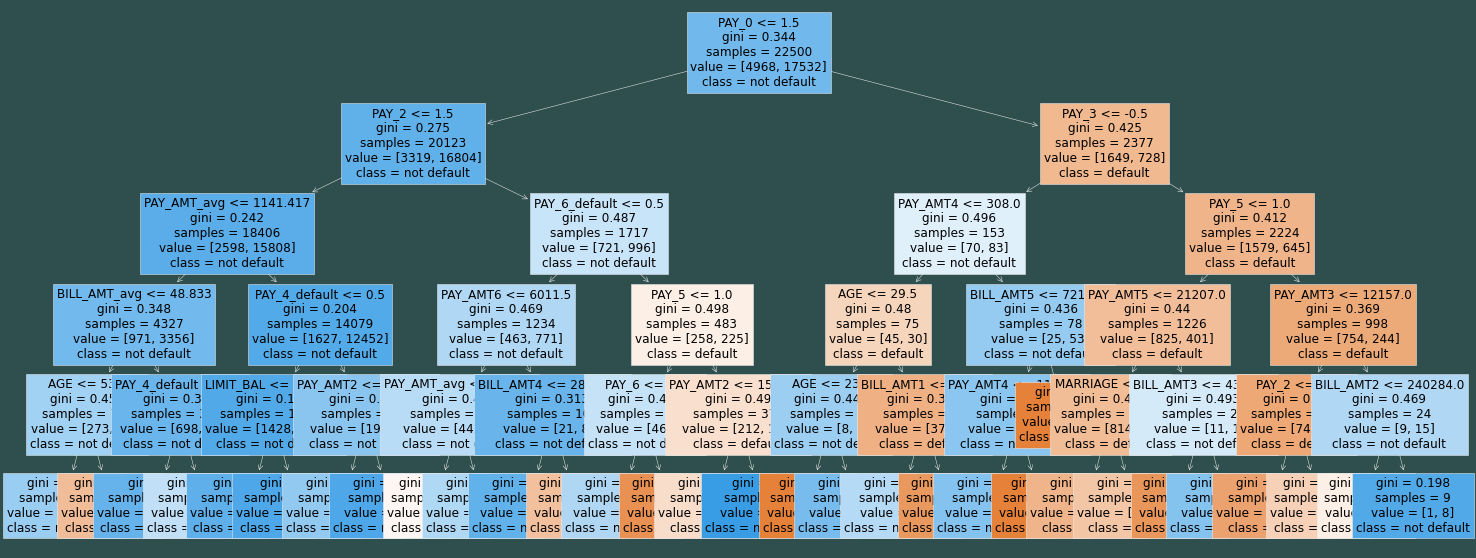

In [81]:
# Plot the tree
plt.figure(figsize = (25, 10), facecolor = 'darkslategrey')
a = plot_tree(algo, 
              filled = True, 
              rounded = False, 
              fontsize = 12, 
              feature_names = ['LIMIT_BAL', 'SEX_ID', 'EDUCATION_ID', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
            'PAY_0_default', 'PAY_2_default', 'PAY_3_default', 'PAY_4_default', 'PAY_5_default', 'PAY_6_default',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
            'PAY_avg', 'BILL_AMT_avg', 'PAY_AMT_avg'],
              class_names = ['default', 'not default']
)

###### The model has a fairly good accuracy of 82%, so it seems to be fairly reliable to predict not-default behavior, but is not very good at predicting the defaults. The recall for 'default' is only .37
###### That is not very helpful, when the goal is to be able to predict the defaults, as it is in this case. This seems to be a widespread problem in the industry, for skewed data.
###### I will try a few other classification models to see what the recall looks like for each of them.

In [82]:
# create an array to store classification models
algosArr = []
algosArr.append(('Random Forest Classification', RandomForestClassifier(max_depth = 5)))
algosArr.append(('Support Vector Classification', SVC()))
algosArr.append(('Gradient Boosting Classification', GradientBoostingClassifier(max_depth = 5)))
#algosArr.append(('Logistic Regression', LogisticRegression()))

In [83]:
# run the models on the dataset and compute score.

results = []
names = []
for name, model in algosArr:
    model_fit = model.fit(X_train, y_train)
    preds = model_fit.predict(X_test)
    names.append(name)
    results.append(classification_report(y_test, preds))

C:\Users\smith\anaconda3\envs\UTA_DA_Smitha\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### A couple of the models above seem to be predicting 0 defaults due to which I see the warning above.

In [84]:
# now print the classification report for each model to see what the accuracy and recall looks like. 

for i in range(len(names)):
    print(names[i],results[i])

Random Forest Classification               precision    recall  f1-score   support

     default       0.68      0.36      0.47      1668
 not default       0.84      0.95      0.89      5832

    accuracy                           0.82      7500
   macro avg       0.76      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500

Support Vector Classification               precision    recall  f1-score   support

     default       0.00      0.00      0.00      1668
 not default       0.78      1.00      0.87      5832

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.60      0.78      0.68      7500

Gradient Boosting Classification               precision    recall  f1-score   support

     default       0.67      0.37      0.47      1668
 not default       0.84      0.95      0.89      5832

    accuracy                           0.82      7500
   macro avg       0.75      0.66   

###### Now try modelling with a smaller set of features, chosen based on the findings of EDA.

###### Slicing with 'default payment next month' as dependent variable

In [85]:
# independent variables
X = credit[['LIMIT_BAL', 'SEX_ID', 'EDUCATION_ID', 'MARRIAGE', 'AGE', 'PAY_avg', 'BILL_AMT_avg', 'PAY_AMT_avg' ]]

In [86]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LIMIT_BAL     30000 non-null  int64  
 1   SEX_ID        30000 non-null  int64  
 2   EDUCATION_ID  30000 non-null  int64  
 3   MARRIAGE      30000 non-null  int64  
 4   AGE           30000 non-null  int64  
 5   PAY_avg       30000 non-null  float64
 6   BILL_AMT_avg  30000 non-null  float64
 7   PAY_AMT_avg   30000 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 1.8 MB


In [87]:
X.head()

,LIMIT_BAL,SEX_ID,EDUCATION_ID,MARRIAGE,AGE,PAY_avg,BILL_AMT_avg,PAY_AMT_avg
0,20000,0,3,1,24,0.0,1284.000000,114.833333
1,120000,0,3,2,26,0.0,2846.166667,833.333333
2,90000,0,3,2,34,0.0,16942.166667,1836.333333
3,50000,0,3,1,37,0.0,38555.666667,1398.000000
4,50000,1,3,1,57,0.0,18223.166667,9841.500000


In [88]:
# dependent variable
y = credit['default payment next month']

In [89]:
y.head()

0        default
1        default
2    not default
3    not default
4    not default
Name: default payment next month, dtype: category
Categories (2, object): [default, not default]

#### Selecting the Model

###### Run cross_val_score across a few different Classification Models to check score for each. Pick the model with the highest accuracy to use for modelling.

In [90]:
# create an array to store classification models
algosArr = []
algosArr.append(('Random Forest Classification', RandomForestClassifier()))
algosArr.append(('Support Vector Classification', SVC()))
algosArr.append(('Decision Tree Classification', DecisionTreeClassifier()))
algosArr.append(('Gradient Boosting Classification', GradientBoostingClassifier()))
algosArr.append(('Logistic Regression', LogisticRegression()))

In [91]:
# run the models on the dataset and compute score.
results = []
names = []
for name, model in algosArr:
    result = cross_val_score(model, X,y, cv=3)
    names.append(name)
    results.append(result)

In [92]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classification 0.7932
Support Vector Classification 0.7788
Decision Tree Classification 0.6963
Gradient Boosting Classification 0.8038
Logistic Regression 0.7788


###### Splitting into Training and Testing Data

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

In [94]:
X_train.head()

,LIMIT_BAL,SEX_ID,EDUCATION_ID,MARRIAGE,AGE,PAY_avg,BILL_AMT_avg,PAY_AMT_avg
26340,150000,0,0,2,26,0.0,59458.333333,2391.666667
3877,50000,0,3,2,23,0.0,27742.666667,1258.000000
27081,80000,1,3,2,31,0.0,74385.333333,3766.666667
5440,120000,0,3,2,39,0.0,24549.000000,1483.333333
22164,150000,0,0,3,30,0.0,2692.333333,2078.166667


In [95]:
y_train.head()

26340    not default
3877     not default
27081    not default
5440     not default
22164    not default
Name: default payment next month, dtype: category
Categories (2, object): [default, not default]

###### Build the Model

In [96]:
# tried with a depth of 3, 4, 5 upto 10. 5 gives the best accuracy
algo = GradientBoostingClassifier(max_depth = 5)

In [97]:
model = algo.fit(X_train, y_train)

### Predictions

In [98]:
preds = model.predict(X_test)

In [99]:
accuracy_score(y_test, preds)

0.8036

In [100]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     default       0.65      0.25      0.36      1668
 not default       0.82      0.96      0.88      5832

    accuracy                           0.80      7500
   macro avg       0.74      0.61      0.62      7500
weighted avg       0.78      0.80      0.77      7500



In [101]:
confusion_matrix(y_test, preds)

array([[ 414, 1254],
       [ 219, 5613]], dtype=int64)

###### The smaller set of features did not provide better prediction results, in fact accuracy dropped by 2% and recall for 'default' prediction dropped even more. Try plotting a few other models with this smaller set of features, just for practice.

In [103]:
# create an array to store classification models
algosArr = []
algosArr.append(('Random Forest Classification', RandomForestClassifier(max_depth = 5)))
algosArr.append(('Support Vector Classification', SVC()))
algosArr.append(('Decision Tree Classification', DecisionTreeClassifier(max_depth = 5)))
algosArr.append(('Gradient Boosting Classification', GradientBoostingClassifier(max_depth = 5)))
algosArr.append(('Logistic Regression', LogisticRegression()))

In [104]:
# run the models on the dataset and compute score.

results = []
names = []
for name, model in algosArr:
    model_fit = model.fit(X_train, y_train)
    preds = model_fit.predict(X_test)
    names.append(name)
    results.append(classification_report(y_test, preds))

C:\Users\smith\anaconda3\envs\UTA_DA_Smitha\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\smith\anaconda3\envs\UTA_DA_Smitha\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### A couple of the models above seem to be predicting 0 defaults due to which I see the warning above.

In [105]:
# now print the classification report for each model to see what the accuracy and recall looks like. 

for i in range(len(names)):
    print(names[i],results[i])

Random Forest Classification               precision    recall  f1-score   support

     default       0.66      0.23      0.34      1668
 not default       0.81      0.97      0.88      5832

    accuracy                           0.80      7500
   macro avg       0.74      0.60      0.61      7500
weighted avg       0.78      0.80      0.76      7500

Support Vector Classification               precision    recall  f1-score   support

     default       0.00      0.00      0.00      1668
 not default       0.78      1.00      0.87      5832

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.60      0.78      0.68      7500

Decision Tree Classification               precision    recall  f1-score   support

     default       0.66      0.25      0.36      1668
 not default       0.82      0.96      0.88      5832

    accuracy                           0.80      7500
   macro avg       0.74      0.61      0

###### With the smaller set of features, SVC and Logistic Regression are not able to identify defaults at all. 
###### Among the rest, the Gradient Boosting Classification model has the highest accuracy. However it has a recall of .25 only for predicting default
###### It appears that with the smaller dataset, the GBC is the best model, but it still is not accurate enough to predict default behavior. It can however be used to predict non-default behavior up to a 96 percent accuracy.

###### I conclude that the resuls I got with the Decision Tree Classifier prevously, using a larger set of X variables, is what I will use for modelling default payment dependent variable